# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `tf.keras.Sequential` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
subject_names/
  Astronomy/
  Biology/
  Chemistry/
  Medicine/
  Physics/
  
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Projects/Sensor & Interface/subject_names.zip'

Archive:  /content/drive/MyDrive/Projects/Sensor & Interface/subject_names.zip
   creating: subject_names/Astronomy/
  inflating: subject_names/Astronomy/20211109_154112.jpg  
  inflating: subject_names/Astronomy/20211109_154114.jpg  
  inflating: subject_names/Astronomy/20211109_154115.jpg  
  inflating: subject_names/Astronomy/20211109_154116.jpg  
  inflating: subject_names/Astronomy/20211109_154117.jpg  
  inflating: subject_names/Astronomy/20211109_154118.jpg  
  inflating: subject_names/Astronomy/20211109_154119.jpg  
  inflating: subject_names/Astronomy/20211109_154120.jpg  
  inflating: subject_names/Astronomy/20211109_154121.jpg  
  inflating: subject_names/Astronomy/20211109_154122.jpg  
  inflating: subject_names/Astronomy/20211109_154123.jpg  
  inflating: subject_names/Astronomy/20211109_154124.jpg  
  inflating: subject_names/Astronomy/20211109_154125.jpg  
  inflating: subject_names/Astronomy/20211109_154126.jpg  
  inflating: subject_names/Astronomy/20211109_154127.jpg 

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/subject_names')
data_dir

PosixPath('/content/subject_names')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

400


Here are some roses:

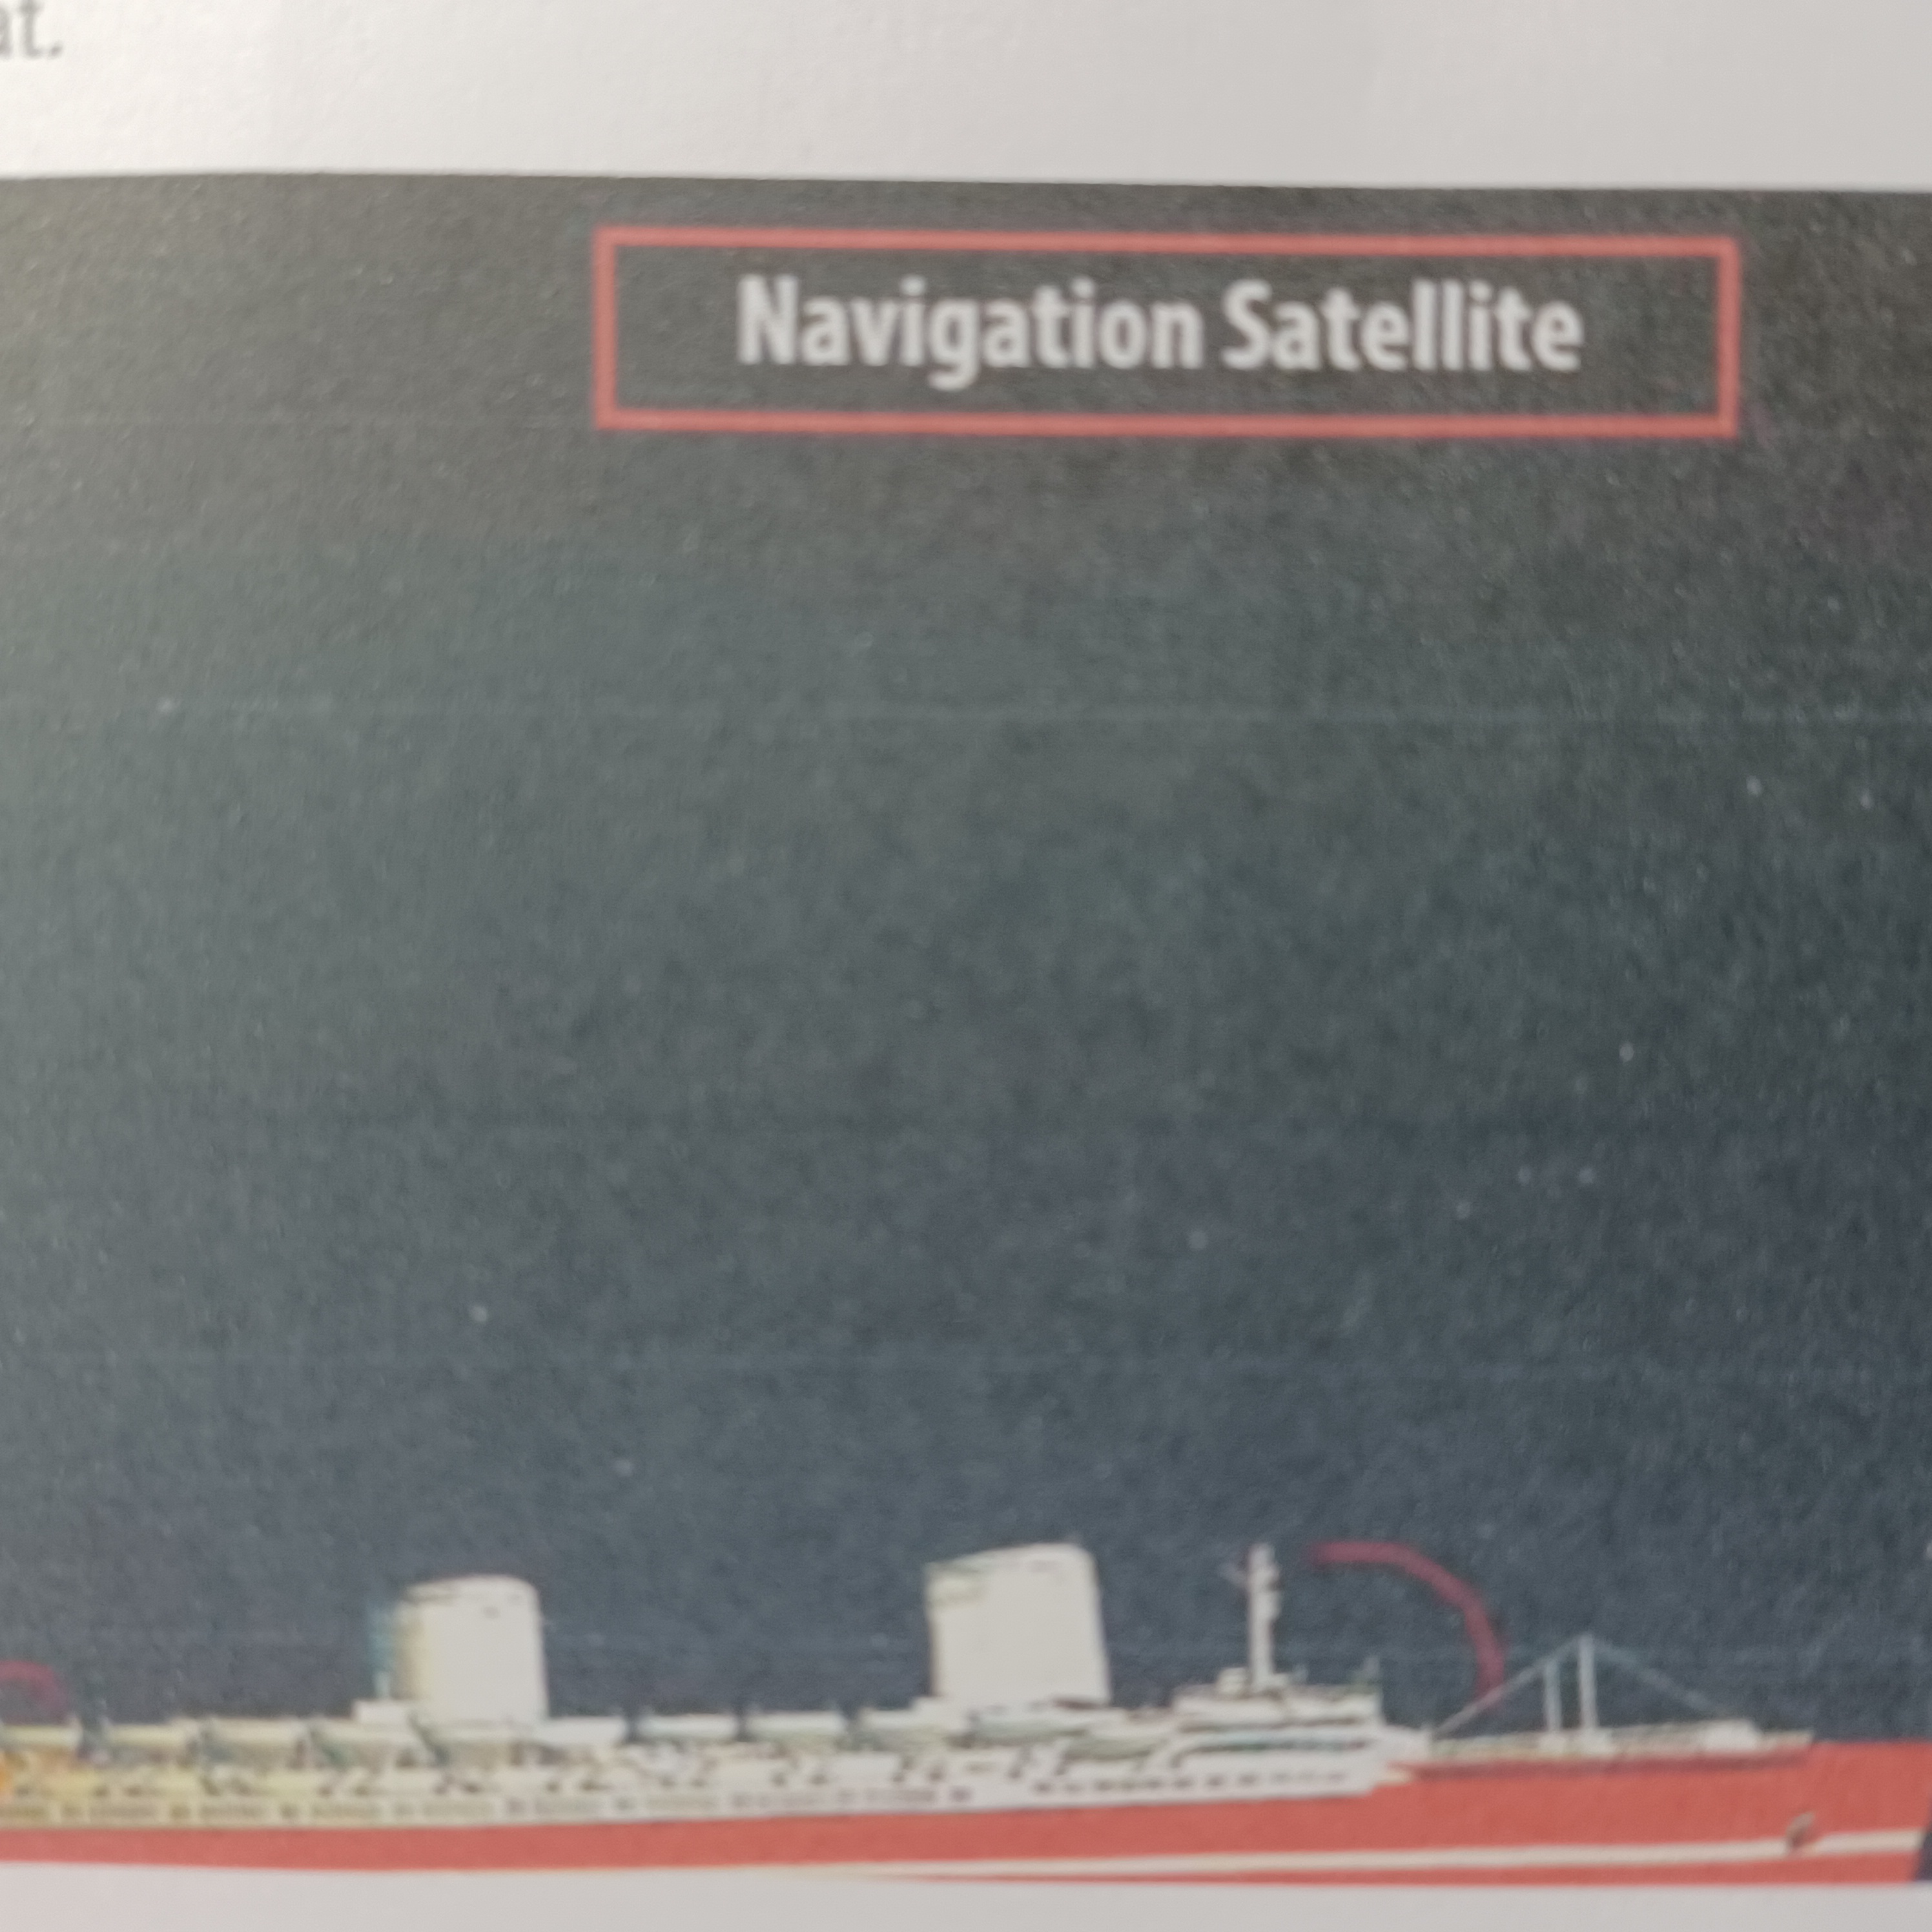

In [ ]:
astronomy = list(data_dir.glob('Astronomy/*'))
PIL.Image.open(str(astronomy[0]))

In [ ]:
# PIL.Image.open(str(astronomy[1]))

And some tulips:

In [ ]:
# biology = list(data_dir.glob('Biology/*'))
# PIL.Image.open(str(biology[0]))

In [ ]:
# PIL.Image.open(str(biology[1]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 5 classes.
Using 320 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 5 classes.
Using 80 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)
test_label = val_ds.class_names
print(test_label)

['Astronomy', 'Biology', 'Chemistry', 'Medicine', 'Physics']
['Astronomy', 'Biology', 'Chemistry', 'Medicine', 'Physics']


## Visualize the data

Here are the first nine images from the training dataset:

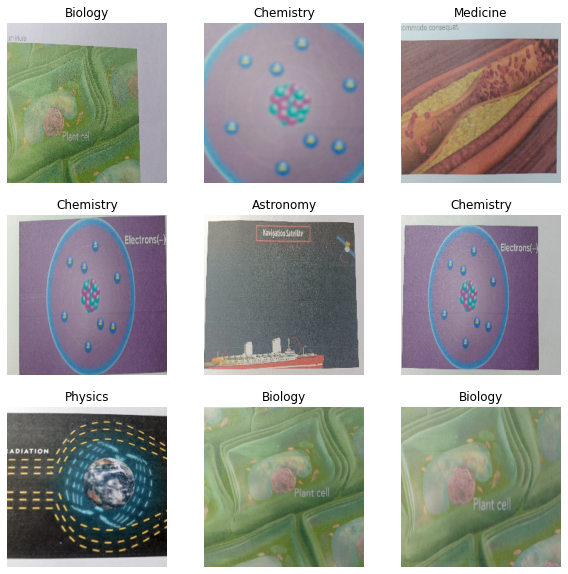

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.15453348 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

def create_model():
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

model = create_model()

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

## Train the model

You can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted. The `tf.keras.callbacks.ModelCheckpoint` callback allows you to continually save the model both during and at the end of training.

Checkpoint callback usage
Create a `tf.keras.callbacks.ModelCheckpoint` callback that saves weights only during training:

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.4746 - accuracy: 0.5063
Epoch 00001: saving model to training_1/cp.ckpt
10/10 [==============================] - 15s 1s/step - loss: 1.4746 - accuracy: 0.5063 - val_loss: 0.5640 - val_accuracy: 0.9625
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9500
Epoch 00002: saving model to training_1/cp.ckpt
10/10 [==============================] - 11s 1s/step - loss: 0.2758 - accuracy: 0.9500 - val_loss: 0.0687 - val_accuracy: 0.9750
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.9031
Epoch 00003: saving model to training_1/cp.ckpt
10/10 [==============================] - 11s 1s/step - loss: 0.2926 - accuracy: 0.9031 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9875
Epoch 00004: saving model to training_1/cp.ckpt
10/10 [==============================] - 12s 

This creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch:

In [ ]:
os.listdir(checkpoint_dir)

['cp.ckpt.data-00000-of-00001', 'checkpoint', 'cp.ckpt.index']

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

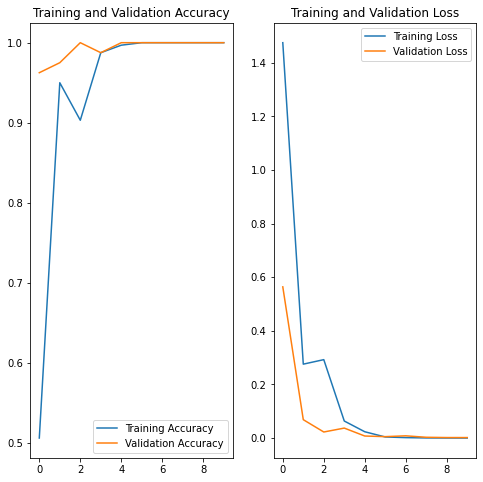

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

Now rebuild a fresh, untrained model and evaluate it on the test set. An untrained model will perform at chance levels (~10% accuracy):

Then load the weights from the checkpoint and re-evaluate:

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

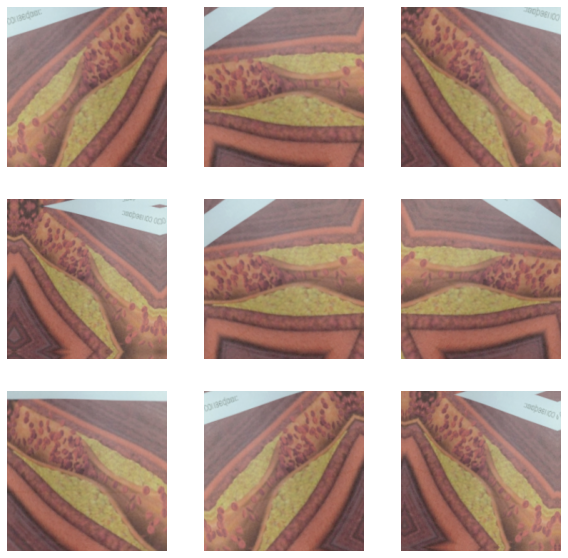

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
def create_model():
  model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = create_model()

## Compile and train the model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)


# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/15
10/10 [==============================] - 17s 2s/step - loss: 1.9947 - accuracy: 0.3250 - val_loss: 1.3387 - val_accuracy: 0.9125
Epoch 2/15
10/10 [==============================] - 23s 2s/step - loss: 1.0039 - accuracy: 0.8250 - val_loss: 0.5195 - val_accuracy: 0.8875
Epoch 3/15
10/10 [==============================] - 19s 2s/step - loss: 0.3613 - accuracy: 0.9094 - val_loss: 0.0860 - val_accuracy: 0.9750
Epoch 4/15
10/10 [==============================] - 20s 2s/step - loss: 0.1839 - accuracy: 0.9406 - val_loss: 0.0956 - val_accuracy: 0.9750
Epoch 5/15
10/10 [==============================] - 16s 2s/step - loss: 0.0598 - accuracy: 0.9875 - val_loss: 0.0320 - val_accuracy: 0.9875
Epoch 6/15
10/10 [==============================] - 13s 1s/step - loss: 0.0268 - accuracy: 0.9969 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 7/15
10/10 [==============================] - 14s 1s/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 8/15
10/10 [==

Now, look at the resulting checkpoints and choose the latest one:

In [ ]:
os.listdir(checkpoint_dir)

['cp-0000.ckpt.data-00000-of-00001', 'cp-0000.ckpt.index', 'checkpoint']

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0000.ckpt'

To test, reset the model and load the latest checkpoint:

In [ ]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('model.json', 'w') as json_file:
    json_file.write(json_model)

# Re-evaluate the model
loss1, acc1 = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc1))

3/3 - 1s - loss: 1.6145 - accuracy: 0.1625 - 1s/epoch - 439ms/step
Restored model, accuracy: 16.25%


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

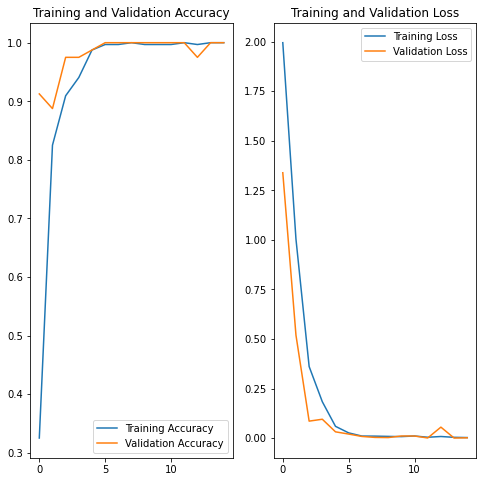

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pip install pyyaml h5py 

Manually saving weights with the `Model.save_weights` method. By default, `tf.keras`—and `save_weights` in particular—uses the TensorFlow checkpoint format with a `.ckpt` extension (saving in HDF5 with a `.h5` extension is covered in the Save and serialize models guide):

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model = create_model()

# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('model1.json', 'w') as json_file:
    json_file.write(json_model)

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

loss2, acc2 = model.evaluate(train_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc2))

10/10 - 4s - loss: 1.6083 - accuracy: 0.1656 - 4s/epoch - 445ms/step
Restored model, accuracy: 16.56%


The SavedModel format is another way to serialize models. Models saved in this format can be restored using `tf.keras.models.load_model` and are compatible with TensorFlow Serving. The SavedModel guide goes into detail about how to serve/inspect the SavedModel. The section below illustrates the steps to save and restore the model.

In [ ]:
model = create_model()
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 1.4611 - accuracy: 0.5375 - val_loss: 0.5544 - val_accuracy: 0.7625
Epoch 2/15
10/10 [==============================] - 13s 1s/step - loss: 0.3053 - accuracy: 0.9187 - val_loss: 0.0499 - val_accuracy: 0.9875
Epoch 3/15
10/10 [==============================] - 13s 1s/step - loss: 0.0393 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9875
Epoch 4/15
10/10 [==============================] - 13s 1s/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/15
10/10 [==============================] - 13s 1s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 6/15
10/10 [==============================] - 13s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 6.0382e-04 - val_accuracy: 1.0000
Epoch 7/15
10/10 [==============================] - 13s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 8/15
10/10

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model.h5')

# Check its architecture
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

In [ ]:
model = create_model()

model.fit(train_ds, epochs=15)

model.save('my_model.h5')

Epoch 1/15
10/10 [==============================] - 13s 1s/step - loss: 1.8683 - accuracy: 0.2406
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 1.3430 - accuracy: 0.3562
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 0.8416 - accuracy: 0.7437
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 0.4192 - accuracy: 0.8469
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 0.1639 - accuracy: 0.9531
Epoch 6/15
10/10 [==============================] - 12s 1s/step - loss: 0.0650 - accuracy: 0.9812
Epoch 7/15
10/10 [==============================] - 12s 1s/step - loss: 0.0273 - accuracy: 0.9969
Epoch 8/15
10/10 [==============================] - 12s 1s/step - loss: 0.0121 - accuracy: 0.9937
Epoch 9/15
10/10 [==============================] - 12s 1s/step - loss: 0.1137 - accuracy: 0.9719
Epoch 10/15
10/10 [==============================] - 12s 1s/step - loss: 0.3226 - accuracy: 0.9000
Epoch 11/15
10/10 [